In [1]:
import torch
import time
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import confusion_matrix
from torchsummary import summary

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cpu


In [3]:
class LightVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(LightVGG, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d(4)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.ReLU(inplace=True),

            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)

        x = x.view(x.shape[0], -1)

        x = self.classifier(x)

        return x

In [4]:
def train_model(model, device, train_loader, val_loader, num_epochs, optimizer, patience):
    start_time = time.time()

    train_losses = []
    val_losses = []

    train_accs = []
    val_accs = []

    counter = 0
    best_val_loss = 0

    for epoch in range(num_epochs):
        model.train()

        running_loss = 0.0
        running_correct = 0

        for batch_idx, (features, targets) in enumerate(train_loader):
            features = features.to(device)
            targets = targets.to(device)

            outputs = model(features)
            loss = F.cross_entropy(outputs, targets)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            running_loss += loss.item()
            _, predicted_labels = torch.max(outputs, 1)
            running_correct += (predicted_labels == targets).sum().item()

            if not batch_idx % 50:
                print(f"Epoch: {epoch+1:02d}/{num_epochs:02d} | Mini-Batch {batch_idx:03d}/{len(train_loader):03d} | Loss: {loss:.4f}")

        train_loss = running_loss / len(train_loader)
        train_acc = running_correct / len(train_loader)

        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()

        with torch.no_grad():
            val_loss, correct_preds, num_examples = 0., 0, 0

            for features, targets in val_loader:
                features = features.to(device)
                targets = targets.to(device)

                outputs = model(features)

                loss = F.cross_entropy(outputs, targets, reduction='sum')

                val_loss += loss

                _, predicted_labels = torch.max(outputs, 1)

                correct_preds += (predicted_labels == targets).sum()

                num_examples += targets.size(0)

            val_loss = val_loss / num_examples

            val_acc = correct_preds.float() / num_examples * 100

            print(f"\nVal Loss: {val_loss:.3f} | Val Accuracy: {val_acc:.3f}\n")

            val_losses.append(val_loss)
            val_accs.append(val_acc)

            if not best_val_loss or val_loss < best_val_loss:
                best_val_loss = val_loss

                counter = 0

            else:
                counter += 1

                if counter == patience:
                    print(f"Early stopping at epoch {epoch + 1}!")

                    break


        print(f"Time elapsed: {((time.time() - start_time) / 60):.2f} min\n\n")

    print(f"Total Training Time: {((time.time() - start_time) / 60):.2f} min\n")


    return train_losses, val_losses, train_accs, val_accs

In [5]:
def model_test(model, device, test_loader):
    model.eval()

    with torch.no_grad():
        correct_preds, num_examples = 0, 0

        for features, targets in test_loader:
            features = features.to(device)
            targets = targets.to(device)

            outputs = model(features)

            _, predicted_labels = torch.max(outputs, 1)

            correct_preds += (predicted_labels == targets).sum()

            num_examples += targets.size(0)

        test_acc = correct_preds.float() / num_examples * 100

        print(f"Test accuracy: {test_acc:.2f}%")

In [6]:
def draw_confusion_matrix(model, device, classes, test_loader):
    model.eval()

    preds = []
    truths = []

    with torch.no_grad():
        for features, targets in test_loader:
            features = features.to(device)
            targets = targets.to(device)

            outputs = model(features)

            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            preds.extend(outputs)

            truths.extend(targets.data.cpu().numpy())

    cf_matrix = confusion_matrix(truths, preds)

    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                         index = [i for i in classes],
                         columns = [i for i in classes])

    plt.figure(figsize = (12,7))

    sn.heatmap(df_cm, annot=True)



In [7]:
def draw_cross_validation(points1, points2, x_label=None, y_label=None, points1_label=None, points2_label=None):
    points1_cpu = torch.Tensor(points1).cpu()
    points2_cpu = torch.Tensor(points2).cpu()

    plt.figure(figsize=(10, 6))

    plt.plot(points1_cpu, label=points1_label)
    plt.plot(points2_cpu, label=points2_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()

    plt.show()

In [8]:
num_classes = 10
learning_rate = 0.001
num_epochs = 25
batch_size = 63
patience = 5

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

dataset = datasets.CIFAR10(root='./data', download=True, transform=transform)

train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)

test_loader = torch.utils.data.DataLoader(test_set,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

Files already downloaded and verified


In [ ]:
model = LightVGG().to(device)

summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
        MaxPool2d-14             [-1, 6

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

train_losses, val_losses, train_accs, val_accs = train_model(model, device, train_loader, val_loader, num_epochs, optimizer, patience)

model_test(model, device, test_loader)

Epoch: 01/25 | Mini-Batch 000/704 | Loss: 2.4892
Epoch: 01/25 | Mini-Batch 050/704 | Loss: 1.7926
Epoch: 01/25 | Mini-Batch 100/704 | Loss: 1.5421
Epoch: 01/25 | Mini-Batch 150/704 | Loss: 1.6282
Epoch: 01/25 | Mini-Batch 200/704 | Loss: 1.6838
Epoch: 01/25 | Mini-Batch 250/704 | Loss: 1.5391
Epoch: 01/25 | Mini-Batch 300/704 | Loss: 1.1866
Epoch: 01/25 | Mini-Batch 350/704 | Loss: 1.1520
Epoch: 01/25 | Mini-Batch 400/704 | Loss: 1.1063
Epoch: 01/25 | Mini-Batch 450/704 | Loss: 1.1547
Epoch: 01/25 | Mini-Batch 500/704 | Loss: 1.3437
Epoch: 01/25 | Mini-Batch 550/704 | Loss: 0.8267
Epoch: 01/25 | Mini-Batch 600/704 | Loss: 1.0345
Epoch: 01/25 | Mini-Batch 650/704 | Loss: 1.0465
Epoch: 01/25 | Mini-Batch 700/704 | Loss: 1.1246

Val Loss: 1.066 | Val Accuracy: 63.040

Time elapsed: 4.64 min


Epoch: 02/25 | Mini-Batch 000/704 | Loss: 1.1493
Epoch: 02/25 | Mini-Batch 050/704 | Loss: 1.1039
Epoch: 02/25 | Mini-Batch 100/704 | Loss: 0.8483
Epoch: 02/25 | Mini-Batch 150/704 | Loss: 0.8573
Epo

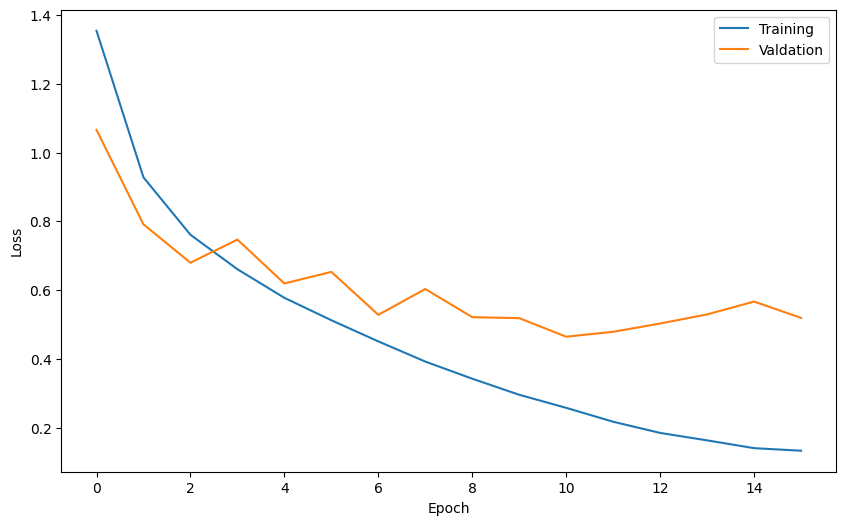

In [ ]:
draw_cross_validation(train_losses, val_losses, "Epoch", "Loss", "Training", "Valdation")

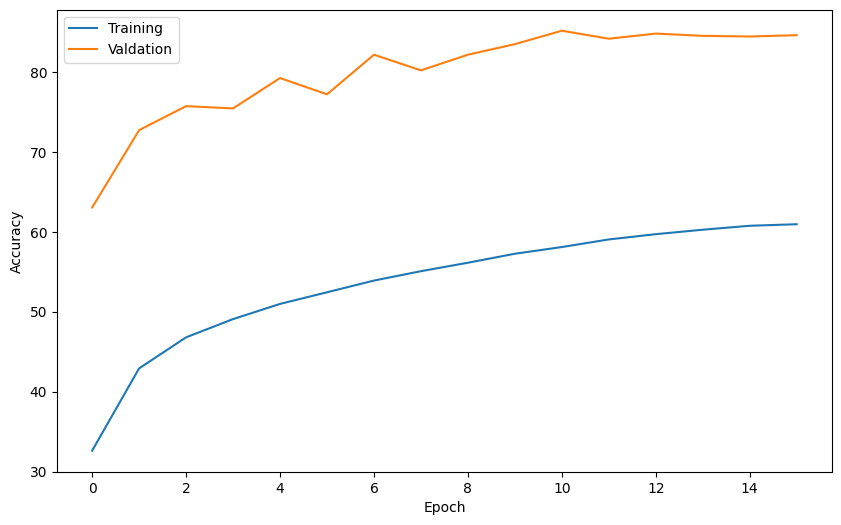

In [ ]:
draw_cross_validation(train_accs, val_accs, "Epoch", "Accuracy", "Training", "Valdation")

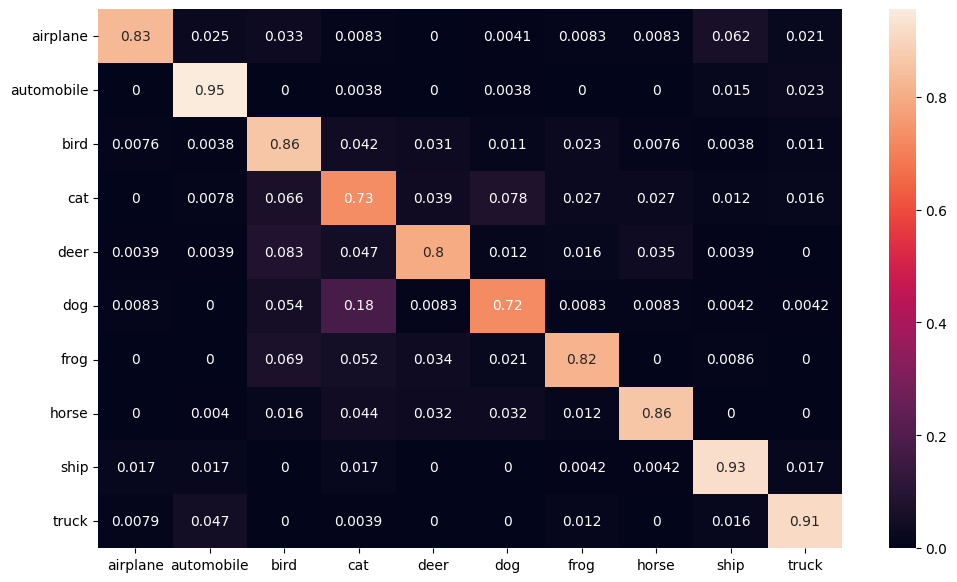

In [ ]:
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

draw_confusion_matrix(model, device, classes, test_loader)

In [ ]:
torch.save(model, "vgg16_cifar10.pt")

In [ ]:
ts_learning_rate = 0.001
ts_num_epochs = 25
ts_patience = 5

In [ ]:
from copy import deepcopy

ts_model = deepcopy(model).to(device)

for param in ts_model.parameters():
    param.requires_grad = False

ts_model.classifier = nn.Sequential(
    nn.Linear(256 * 4 * 4, 512),
    nn.Dropout(p=0.5),
    nn.ReLU(inplace=True),


    nn.Linear(512, 512),
    nn.Dropout(p=0.5),
    nn.ReLU(inplace=True),

    nn.Linear(512, num_classes),
).to(device)

summary(ts_model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
      BatchNorm2d-12           [-1, 64, 16, 16]             128
             ReLU-13           [-1, 64, 16, 16]               0
        MaxPool2d-14             [-1, 6

In [ ]:
ts_optimizer = torch.optim.Adam(ts_model.parameters())

ts_train_losses, ts_val_losses, ts_train_accs, ts_val_accs = train_model(ts_model, device, train_loader, val_loader, ts_num_epochs, ts_optimizer, ts_patience)

model_test(model, device, test_loader)

Epoch: 01/25 | Mini-Batch 000/704 | Loss: 2.2955
Epoch: 01/25 | Mini-Batch 050/704 | Loss: 1.4331
Epoch: 01/25 | Mini-Batch 100/704 | Loss: 0.9537
Epoch: 01/25 | Mini-Batch 150/704 | Loss: 0.9990
Epoch: 01/25 | Mini-Batch 200/704 | Loss: 1.0602
Epoch: 01/25 | Mini-Batch 250/704 | Loss: 1.1402
Epoch: 01/25 | Mini-Batch 300/704 | Loss: 0.7270
Epoch: 01/25 | Mini-Batch 350/704 | Loss: 0.8639
Epoch: 01/25 | Mini-Batch 400/704 | Loss: 0.4685
Epoch: 01/25 | Mini-Batch 450/704 | Loss: 0.5023
Epoch: 01/25 | Mini-Batch 500/704 | Loss: 0.5109
Epoch: 01/25 | Mini-Batch 550/704 | Loss: 0.5198
Epoch: 01/25 | Mini-Batch 600/704 | Loss: 0.6004
Epoch: 01/25 | Mini-Batch 650/704 | Loss: 0.5154
Epoch: 01/25 | Mini-Batch 700/704 | Loss: 0.5223

Val Loss: 0.590 | Val Accuracy: 80.120

Time elapsed: 1.92 min


Epoch: 02/25 | Mini-Batch 000/704 | Loss: 0.7042
Epoch: 02/25 | Mini-Batch 050/704 | Loss: 0.6612
Epoch: 02/25 | Mini-Batch 100/704 | Loss: 0.5860
Epoch: 02/25 | Mini-Batch 150/704 | Loss: 0.6030
Epo

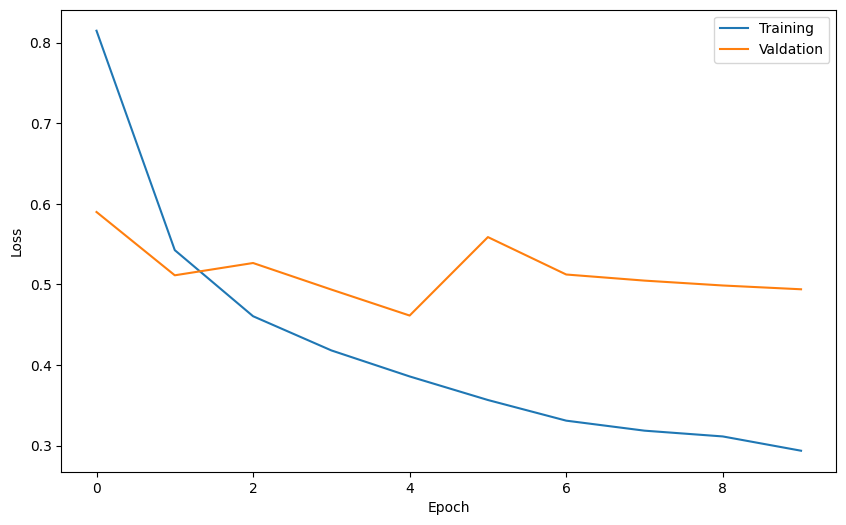

In [ ]:
draw_cross_validation(ts_train_losses, ts_val_losses, "Epoch", "Loss", "Training", "Valdation")

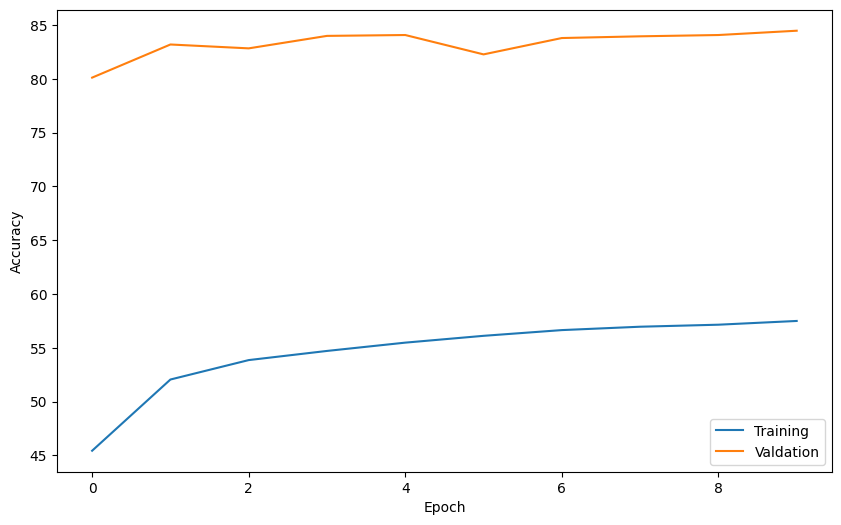

In [ ]:
draw_cross_validation(ts_train_accs, ts_val_accs, "Epoch", "Accuracy", "Training", "Valdation")

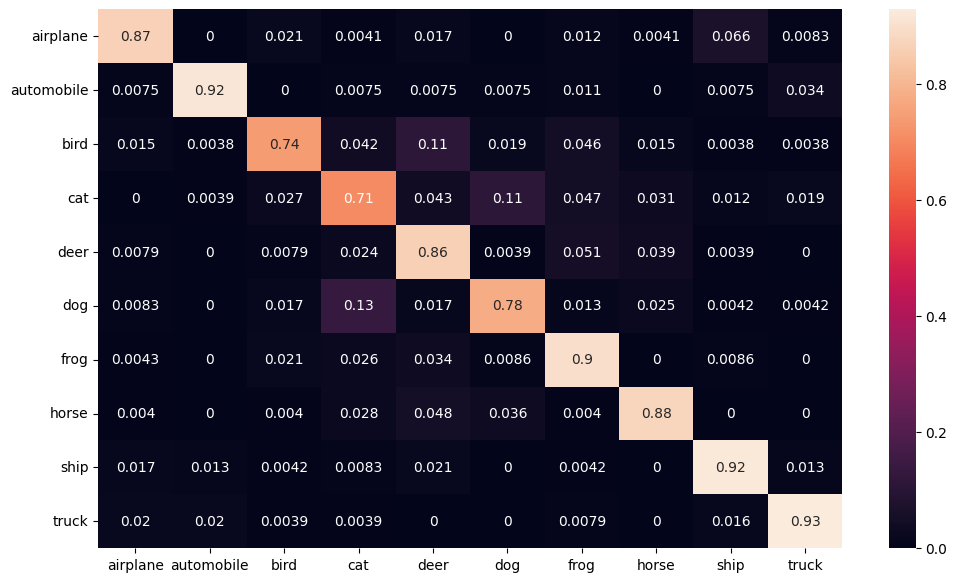

In [ ]:
draw_confusion_matrix(ts_model, device, classes, test_loader)

In [10]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()

        dropout = 0.1

        self.features = nn.Sequential(
            nn.Conv2d(in_channels,
                        out_channels,
                        kernel_size=3,
                        stride=stride,
                        padding=1,
                        bias=False),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels,
                        out_channels,
                        kernel_size=3,
                        stride=1,
                        padding=1,
                        bias=False),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout),
        )

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels,
                            out_channels,
                            kernel_size=1,
                            stride=stride,
                            bias=False),
                nn.BatchNorm2d(out_channels),
                nn.Dropout(dropout),
            )

    def forward(self, x):
        out = self.features(x)

        out += self.skip(x)

        out = nn.ReLU(inplace=True)(out)

        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            Block(64, 64, stride=1),
            Block(64, 64, stride=1),

            Block(64, 128, stride=2),
            Block(128, 128, stride=1),

            Block(128, 256, stride=2),
            Block(256, 256, stride=1),

            nn.AdaptiveAvgPool2d((1,1)),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256, num_classes),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        x = self.features(x)

        x = x.view(x.size(0), -1)

        x = self.classifier(x)

        return x

In [11]:
model = ResNet().to(device)

summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
           Dropout-6           [-1, 64, 32, 32]               0
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
          Dropout-10           [-1, 64, 32, 32]               0
            Block-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
          Dropout-14           [-1, 64,

In [ ]:
optimizer = torch.optim.Adam(model.parameters())

train_losses, val_losses, train_accs, val_accs = train_model(model, device, train_loader, val_loader, num_epochs, optimizer, patience)

model_test(model, device, test_loader)